In [1]:
import os
from pyspark.storagelevel import StorageLevel


os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"
)

import pyspark
from pyspark.sql import SparkSession
from App.utils import *
from graphframes import *

hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"

conf = pyspark.SparkConf().setAppName("Explore Entry Record").setMaster("local[*]")
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

resident_file_dest = "resident.parquet"
place_file_dest = "place.parquet"
safe_entry_file_dest = "entry_record.parquet"
contact_graph_edge_file_dest = "contact_graph_edge.parquet"
contact_graph_vertex_file_dest = "contact_graph_vertex.parquet"

communities_file_dest = "communities.parquet"

#### Step 1: Retrieve Graph Data

In [2]:
e = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_edge_file_dest)
v = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_vertex_file_dest)
g = GraphFrame(v, e)
g.cache()
g.edges.show()
g.vertices.show()


+--------+--------+
|     src|     dst|
+--------+--------+
|S001140L|F001576U|
|F001576U|S001140L|
|S001140L|F001596J|
|F001596J|S001140L|
|F001642K|S001386E|
|S001386E|F001642K|
|F000575D|S001245Q|
|S001245Q|F000575D|
|S000913M|F001151X|
|F001151X|S000913M|
|F001705G|S000759D|
|S000759D|F001705G|
|F001885E|F001754W|
|F001754W|F001885E|
|F001885E|S000566W|
|S000566W|F001885E|
|S000766Y|S001216E|
|S001216E|S000766Y|
|F001754W|S000566W|
|S000566W|F001754W|
+--------+--------+
only showing top 20 rows

+-----------+----------------+--------+------------+--------------------+
|resident_id|   resident_name|      id|phone_number|      last_update_dt|
+-----------+----------------+--------+------------+--------------------+
|      rid_1| resident_name_1|S000001U|    80000001|2021-04-13 23:22:...|
|      rid_2| resident_name_2|S000002J|    80000002|2021-04-13 23:22:...|
|      rid_3| resident_name_3|F000003Q|    80000003|2021-04-13 23:22:...|
|      rid_4| resident_name_4|F000004E|    8000000

#### Step 2: visualize in NetworkX

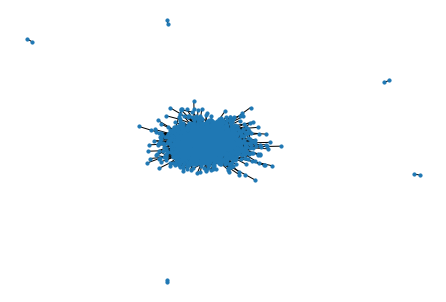

In [3]:
g_pdf = g.edges.select("*").toPandas()

import networkx as nx
import matplotlib.pyplot as plt
g_nx = nx.from_pandas_edgelist(g_pdf, source='src', target='dst')
nx.draw(g_nx,node_size = 10)
plt.show()

#### Step 3.1: Find Close Node

In [5]:
from pyspark.sql.functions import explode

confirmed_cases = ['F001576U']

shortest_path_df = g.shortestPaths(landmarks=confirmed_cases)
shortest_path_df.select("id", "distances").orderBy('id').show(20,False)

shortest_path_df=shortest_path_df.select("id", explode("distances"))

print(f"============close contact as below============")
shortest_path_df.filter(shortest_path_df.value == 1).show()

+--------+---------------+
|id      |distances      |
+--------+---------------+
|F000003Q|[F001576U -> 5]|
|F000004E|[F001576U -> 9]|
|F000006D|[F001576U -> 5]|
|F000007E|[F001576U -> 6]|
|F000010H|[F001576U -> 5]|
|F000012O|[F001576U -> 4]|
|F000015T|[F001576U -> 4]|
|F000017L|[F001576U -> 3]|
|F000019Q|[F001576U -> 5]|
|F000020N|[F001576U -> 4]|
|F000023U|[F001576U -> 5]|
|F000024G|[F001576U -> 5]|
|F000025W|[F001576U -> 7]|
|F000026E|[F001576U -> 6]|
|F000027T|[F001576U -> 4]|
|F000029J|[F001576U -> 5]|
|F000030M|[F001576U -> 7]|
|F000031I|[F001576U -> 6]|
|F000033K|[F001576U -> 5]|
|F000035B|[F001576U -> 5]|
+--------+---------------+
only showing top 20 rows

============close contact as below============
+--------+--------+-----+
|      id|     key|value|
+--------+--------+-----+
|S001140L|F001576U|    1|
|F001364I|F001576U|    1|
|S000809Z|F001576U|    1|
|F001972C|F001576U|    1|
|S000989M|F001576U|    1|
|F001020C|F001576U|    1|
+--------+--------+-----+



#### Step 3.2: Community Detection
##### Build model, can not use SCC and CC

In [7]:
communities_df = g.labelPropagation(maxIter=10)

from pyspark.sql import functions as func
communities_df.sort("label").groupby("label").agg(func.collect_list("id")).show()

communities_df.orderBy("label").show()

communities_hdfs_path = hdfs_host + hdfs_root_path + communities_file_dest
communities_df.write.mode("Overwrite").parquet(communities_hdfs_path)

+------------+--------------------+
|       label|    collect_list(id)|
+------------+--------------------+
|           5|[S000212Z, S000901N]|
| 34359738368|          [F000168K]|
| 42949672962|[F001435G, F000858Z]|
| 42949672966|          [S000071E]|
| 51539607557|          [F001242Q]|
| 51539607562|          [S001365E]|
| 68719476738|          [F001349T]|
| 68719476743|[F001393E, F00193...|
| 94489280521|          [S001307S]|
|120259084288|          [F000274B]|
|154618822656|          [F000114Q]|
|154618822665|          [F001330P]|
|154618822666|          [F001419H]|
|163208757254|[F000954Y, S00067...|
|171798691841|          [F000441J]|
|180388626442|[S001901L, S00043...|
|206158430211|          [F001239X]|
|206158430217|          [S001653E]|
|231928233988|[F001382T, S00157...|
|240518168576|          [F001578Y]|
+------------+--------------------+
only showing top 20 rows

+-----------+------------------+--------+------------+--------------------+------------+
|resident_id|     res

##### Find Cluster for resident

In [10]:
resident_id = 'F000006D'
label = communities_df.filter("id = '" + resident_id + "'" ).collect()[0]['label']

print('============Resident in the same cluster============')
communities_df.filter("label = '"+ str(label) +"'").show()

============Resident in the same cluster============
+-----------+------------------+--------+------------+--------------------+------------+
|resident_id|     resident_name|      id|phone_number|      last_update_dt|       label|
+-----------+------------------+--------+------------+--------------------+------------+
|    rid_484| resident_name_484|F000484L|    90000484|2021-04-13 23:22:...|549755813888|
|   rid_1362|resident_name_1362|S001362C|    90001362|2021-04-13 23:22:...|549755813888|
|    rid_716| resident_name_716|S000716D|    80000716|2021-04-13 23:22:...|549755813888|
|     rid_13|  resident_name_13|S000013A|    80000013|2021-04-13 23:22:...|549755813888|
|   rid_1663|resident_name_1663|F001663X|    90001663|2021-04-13 23:22:...|549755813888|
|      rid_6|   resident_name_6|F000006D|    80000006|2021-04-13 23:22:...|549755813888|
|    rid_344| resident_name_344|F000344D|    90000344|2021-04-13 23:22:...|549755813888|
|    rid_942| resident_name_942|F000942F|    90000942|202

##### Un-persist cache

In [15]:
g.unpersist()

GraphFrame(v:[id: string, resident_name: string ... 3 more fields], e:[src: string, dst: string])